### Correlated SEP Events $\rightarrow$ Proton Flux as a function of:

- CME Speed  
- GOES Peak Flare Flux

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
from scipy.stats import linregress
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

In [2]:
# Defining the path for the dataframe
custom_df = 'C:/Users/Peter/py_projects/solar_stats/custom_df.p'

# Importing the dataframe
df = pd.read_pickle(custom_df)

# Reading in SEP dataframe
custom_df1 = 'C:/Users/Peter/py_projects/solar_stats/custom_sep.p'
sp = pd.read_pickle(custom_df1)

In [3]:
# df data
all_regions = df.srs_active_region_no.dropna(how='any').astype(float)
sp_regions = sp.region.dropna(how='any')
print(sp_regions[pd.to_numeric(sp_regions, errors='coerce').isnull()])

sp_regions.replace('9212,13,18','9212', regex=True, inplace=True)
sp_regions.replace('Filament', np.nan, regex=True, inplace=True)

# Dropping the 'filament' nan
sp_regions = sp_regions.dropna(how='any').astype(float)

# Looking at which entries in all_regions match any from sp_regions
bools = all_regions.isin(sp_regions)

# keeping entries of boolean True only
bools = bools[bools]

# Getting the True indices and using to create a new filtered df 
idx = bools.index.tolist()
df2 = df.loc[idx]

# Properties to look at (limiting to max and min dates from the SEP data)
fls = df2[['flare_start_time', 'flare_peak_time', 'cme_speed', 'srs_active_region_no', 'goes_flux']]
fls = fls.dropna(how='any')
fls = fls[ (fls['flare_start_time'] >= dt.datetime(1997, 11, 4)) & (fls['flare_start_time'] <= dt.datetime(2017, 9, 6)) ] 
fls = fls.reset_index(drop=True)

spf = sp[['proton_flux', 'flare_max', 'region']]
spf = spf.dropna(how='any')
spf = spf.reset_index(drop=True)

23      Filament
26    9212,13,18
Name: region, dtype: object


In [4]:
# Finding the entries between both dataframes that exactly match (in terms of peak flare times) to each other
fls_times = fls.flare_peak_time
spf_times = spf.flare_max

a = spf_times.isin(fls_times)
a=a[a]

b = fls_times.isin(spf_times)
b=b[b]

# Getting the True indices and using to create a new filtered dfs
idxa = a.index.tolist()
idxb = b.index.tolist()
adf = spf.loc[idxa]
bdf = fls.loc[idxb]

In [5]:
# Now correlating each of these 'filtered' dfs to each other by finding the nearest times of each event

# Function to find nearest values: find the value in the 'items' column closest to the 'pivot' value
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [6]:
# Nearest values between flare_peak_time and SEP flare_max 
x = (np.zeros(len(adf.flare_max))).astype('O')
for i in range(len(x)):
    x[i] = nearest(bdf.flare_peak_time, adf.flare_max.iloc[i])
    
# Now getting the indices for these nearest values
y = np.zeros(len(x))
for j in range(len(y)):
    z = bdf['flare_peak_time'].index[bdf.flare_peak_time==x[j]].tolist()
    y[j] = z[0]
    
# Now to keep only the corresponding data for these entries
new_df = bdf.loc[y]    

In [7]:
# Making a very simple linear fit
fit1_stats = linregress(new_df.cme_speed, np.log10(adf.proton_flux)) 
fit2_stats = linregress(np.log10(new_df.goes_flux), np.log10(adf.proton_flux)) 

print(fit1_stats,'\n')
print(fit2_stats)

LinregressResult(slope=0.0007900445439336871, intercept=1.0710059777230767, rvalue=0.49124727485878256, pvalue=0.00018764139604928072, stderr=0.000196152813480183) 

LinregressResult(slope=0.9382602423987284, intercept=6.0261733368137005, rvalue=0.5709548508068198, pvalue=8.032236627305268e-06, stderr=0.1889164642821409)


In [27]:
# Standard errors for the correlation coeffs
r1 = fit1_stats[2]
r2 = fit2_stats[2]

rse1 = np.sqrt(1-r1**2)/np.sqrt(len(new_df.cme_speed)-2)
rse2 = np.sqrt(1-r2**2)/np.sqrt(len(new_df.goes_flux)-2)

print(rse1)
print(rse2)

0.12196721794728443
0.11496039883711039


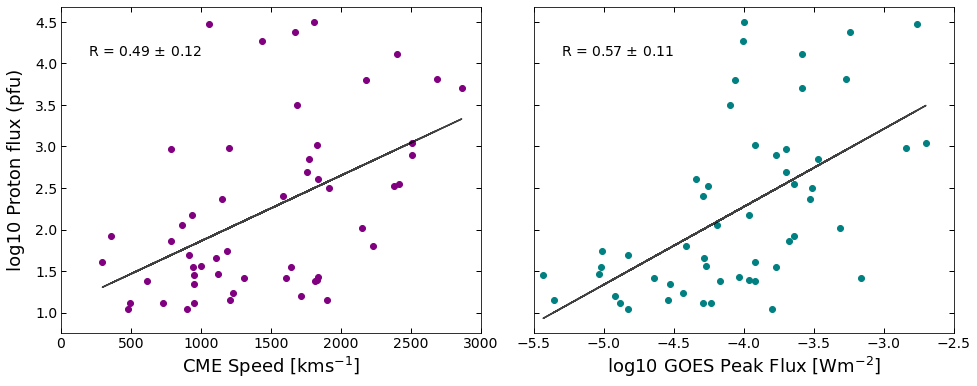

In [31]:
#=== PLOTTING ==================================================================================================================
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey='row', facecolor='white')
fig1.subplots_adjust(wspace=0.125)

# CME speed
sct1 = ax1.scatter(new_df.cme_speed, np.log10(adf.proton_flux), c='purple')
#ax1.set_title('CME Speed vs Proton Flux (1997 - 2017)', fontsize=18)
ax1.set_xlabel('CME Speed [kms$^{-1}$]', fontsize=18)
ax1.set_ylabel('log10 Proton flux (pfu)', fontsize=18, labelpad=10)
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
ax1.set_xlim([0,3000])
ax1.xaxis.set_minor_locator(MultipleLocator(100))
ax1.tick_params(axis='both', length=5, top=True, right=True, direction='in', width=1)
ax1.tick_params(axis='both', length=2, top=False, right=True, bottom=False, direction='in', which='minor', width=1)

#fit
ax1.text(0.2, 0.85, r'R = 0.49 $\pm$ 0.12', fontsize=14, horizontalalignment='center', transform=ax1.transAxes)
ax1.plot(new_df.cme_speed, fit1_stats.intercept + fit1_stats.slope*new_df.cme_speed, 'k-', alpha=0.75)


# GOES flux
sct2 = ax2.scatter(np.log10(new_df.goes_flux), np.log10(adf.proton_flux), c='teal')
#ax2.set_title('GOES Flux vs Proton Flux (1997 - 2017)', fontsize=18)
ax2.set_xlabel('log10 GOES Peak Flux [Wm$^{-2}$]', fontsize=18)
ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)
ax2.set_xlim([-5.5,-2.5])
ax2.tick_params(axis='both', length=5, top=True, right=True, direction='in', width=1)
ax2.tick_params(axis='both', length=2, top=True, right=True, direction='in', which='minor', width=1)

#fit
ax2.text(0.2, 0.85, r'R = 0.57 $\pm$ 0.11', fontsize=14, horizontalalignment='center', transform=ax2.transAxes)
ax2.plot(np.log10(new_df.goes_flux), fit2_stats.intercept + fit2_stats.slope*np.log10(new_df.goes_flux), 'k-', alpha=0.75)

#plt.savefig('spe_plots_v2.png', dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()